# Machine Learning Engineering (MLE)


[MLE](http://mlebook.com/) se refiere al diseño y construcción de software que incluye componentes basados en modelos de Machine Learning (ML). En este sentido, MLE se puede considerar como una extensión de la [ingeniería de software](https://es.wikipedia.org/wiki/Ingenier%C3%ADa_de_software) tradicional

Hasta ahora nos hemos concentrado en presentar los aspectos más científicos de como entrenar y evaluar modelos de ML. MLE concierne no sólo el entrenamiento sino también aspectos relacionados a la colección y corrección de datos y al monitoreo y mantenimiendo de los modelos

## Ciclo de vida de un proyecto de ML

Las tareas para desarrollar un sofware que utiliza ML pueden dividirse en

1. Recolección y preparación de datos
1. Ingeniería de *features* (características)
1. Entrenamiento de modelos
1. Evaluación de modelos
1. Deployment de modelos
1. Servir modelos 
1. Monitoreo de modelos
1. Mantenimiento de modelos

Donde además se asume como "paso 0" la definición de uno o más objetivos, que vienen a ser los requisitos del software

:::{important}

El objetivo debe definir las entradas y salidas del modelo. El objetivo también debe definir el criterio o métrica con la que se medirá que tan exitoso es el modelo

:::

:::{note}

El movimiento entre los pasos anteriores puede ser "hacia atrás", por ejemplo ante una mala evaluación del modelo o errores detectados en el monitoreo, podríamos retroceder a recolectar nuevos datos y reetrenar el modelo

:::

Los pasos 3 y 4 han sido revisados en detalle para diversos modelos (regresión logística, SVM, árboles, etc). A continuación revisaremos los demás pasos del flujo anterior. Pero antes respondamos la siguiente pregunta:


**¿Cuándo incorporar ML en mi software?**

ML provee herramientas para aprender modelos de predicción automáticamente a partir de datos. Antes de implementar corresponde preguntar si:

- El problema no puede resolverse en base a heurísticas o reglas que puedan programarse "a mano" (o se necesita una cantidad de reglas demasiado grande) 
- El costo (monetario o horas humanas) de obtener y etiquetar los datos necesarios no es demasiado alto
- El problema tiene un objetivo simple y bien específicado
- El problema puede admitir algunas respuestas erróneas (accuracy no necesita ser 100%)

Si alguna de las anteriores no se cumple, deberíamos cuestionar el uso de ML en nuestro sofware 

Otro indicio importante es si el problema en cuestion está relacionado a percepción humana, por ejemplo reconocimiento de patrones en imágenes (visión) o sonido (audición). En esos casos ML es en general la mejor solución




## Recolección y preparación de datos



Antes de entrenar un modelo se necesitan datos. Antes de iniciar una campaña de recolección de datos que permitan cumplir el objetivo deberíamos investigar si:

- hay datos existentes que pueden utilizarse 
- los datos son suficientes para todas las clases/eventos de interés
- los datos son relativamente actuales (no están obsoletos)
- los datos tienen calidad suficiente 

Los problemas típicamente encontrados en datasets de baja calidad son:

- Ruido en los datos
- Ruido en las etiquetas: Etiquetadores inconsistentes
- Datos faltantes (*missing data*)
- Sesgos de selección, muestreo, variables omitidas, etc
- Presencia de *outliers*: Ejemplos muy alejados de la distribución que pueden afectar el entrenamiento
- *data leakage*: La variable objetivo (etiqueta) está oculta en alguna de las variables

Algunos de estos problemas puede resolverse mediante

- Adecuado particionamiento de los datos
- Inputación: Se refiere a rellenar datos faltantes utilizando reglas simples
- Balanceo de clases mediante submuestreo (aleatorio o clustering), sobremuestreo (repetición) o aumentación sintética (por ejemplo [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))
- Aumentación: Se refiere a crear sintéticamente nuevos datos basados en los existentes


:::{seealso}

Para trabajar con datos desbalanceados utilizando los esquemas mencionados sugiero la librería [imbalanced-learn](https://imbalanced-learn.org/stable/index.html)

:::

Si no podemos resolver el problema usando estas técnicas sería necesario recolectar datos propios o re-etiquetar los datos existentes

:::{seealso}

Para etiquetar datos de series de tiempo, texto, audio, imágenes de forma  colaborativa y organizanda recomiendo el software [LabelStudio](https://labelstud.io/)

:::

Si los datos cambian con cierta frecuencia, viven en distintos servidores y/o necesitan ser compartidos y coordinados en un equipo conviene utilizar **versionamiento**

El versionamiento de datos es un concepto reciente, muy similar al versionamiento de código:

- Cada cambio en nuestros datos es anotado mediante un *commit*
- Los cambios hechos por distintas personas pueden coordinarse de forma centralizada
- Se puede revisar fácilmente la historia de cambios y retroceder a un cambio anterior si es necesario

:::{seealso}

Para realizar versionanamiento de datos sugiero la [Data Version Control](https://dvc.org/) (DVC), la cual está basada en git

:::

## Ingeniería de características 



Es muy común que los datos recolectados para resolver un problema de ML no estén originalmente en formato o tipo compatible con el modelo de aprendizaje. Por ejemplo, la mayoría de los métodos que hemos visto en este curso requieren una entrada numérica

**Ejemplo** Supongamos que tenemos un dataset de helados y uno de sus atributos es la marca de la empresa que produce el helado: Savory, Bresler, Panda. 

Si queremos utilizar la marca como una entrada a un modelo predictivo podríamos codificar estas categorías como numéros enteros utilizando [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

In [1]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

marcas = np.array(['Savory', 'Bresler', 'Panda'])

enc = OrdinalEncoder()
enc.fit_transform(marcas.reshape(-1, 1))

array([[2.],
       [0.],
       [1.]])

In [2]:
enc.inverse_transform([[0]])

array([['Bresler']], dtype='<U7')

:::{error}

Esta forma ingenua de codificar las categorías introduce una relación de orden ficticia que el modelo podría aprender

:::

:::{note}

Si el número de categorías no es grande, podemos codificarlas sin caer en una relación de orden utilizando one-hot encoding

:::

Podemos implementar esta codificación con [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

In [3]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
enc.fit_transform(marcas.reshape(-1, 1))

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [4]:
enc.inverse_transform([[0, 0, 1]])

array([['Savory']], dtype='<U7')

donde todas las categorías están a una misma distancia de las demás. Esta secuencia de tres números puede ingresar como entrada al modelo

:::{note}

En problemas con muchas categorías estaríamos creando vectores de gran tamaño. Un solución típica es agrupar las categorías minoritarias. Esto se puede hacer con `OneHotEncoder` utilizando el argumento `max_categories`

:::

Más en general, podemos definir:

Característica (feature)
: Se refiere a una cantidad obtenida de codificar o transformar los datos (crudos) que puede usarse como entrada de un modelo. 

Ingeniería de características (feature engineering)
: Se refiere a los criterios y procesos para diseñar y obtener características a partir de datos crudos

Una característica "ideal" debería cumplir con lo siguiente

- Alto poder predictor: La característica debe estar altamente relacionada con la variable a predecir (etiqueta)
- Baja correlación con otras características: La característica no debe proveer información que esté en otras características
- Alta confianza: La característica debe calcularse a partir de datos que son confiables y representativos del problema
- Rápida de calcular: El cálculo de la característica no debería introducir un *overhead* computacional que vuelva infactible resolver el problema

:::{important}

La ingeniería de características es un proceso creativo que requiere de un acercamiento importante al problema que se quiere resolver

:::

**Discusión:** Un médico quiere predecir [cancer a partir de una biopsia](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data). El médico resuelve esta tarea observando el tamaño de ciertas células que se caracterisan por su color distintivo ¿Qué características diseñar para este problema?


Si en un problema particular los datos corresponden a los siguientes tipos, podemos considerar las siguientes representaciones para obtener características:

- Textos: [Modelos de tópicos](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) (LDA), Bag of Words, Word2Vec
- Audio: [Espectrogramas](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html), [Wavelets](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cwt.html)
- Imágenes: [Filtros de extracción de contornos, Gradientes de color, matching de geométrias](https://scikit-image.org/), 
- Series de tiempo: [Modelos autoregresivos](https://www.sktime.org/en/stable/)

Ejemplo de características para un dominio particular: [astronomía](http://isadoranun.github.io/tsfeat/FeaturesDocumentation.html)

### Selección de características

Los métodos de selección de características buscan encontrar el subconjunto de características más relevantes para resolver el problema (clasificación o regresión). En el caso más general estos métodos suelen distinguir entre:

Características relevante
: Es una características que tiene alto poder predictivo, es decir una relación (lineal o no lineal) fuerte con la variable a predecir (etiqueta)

Características complementarias o sinérgicas
: Son tuplas de características que por si sola tienen bajo poder predictivo, pero estándo juntas tienen alto poder predictivo

Característica redundante
: Es una característica que si se elimina no afecta el desempeño pues su relación con la etiqueta ya está bien representada por otras variables

Característica irrelevante
: Es una característica con relación débil o nula con la etiqueta

:::{important}

Un buen método de selección debería preservar las características relevantes/complementarias y descartar las irrevelante/redundantes

:::

:::{note}

Eliminar características de poco poder predictivo puede mejorar el rendimiento del clasificador, especialmente si tenemos muchas características (la maldición de la dimensionalidad)


:::

El módulo [`feature_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) de Scikit-Learn ofrece algunas alternativas para hacer selección de características. Revisemos primero [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). Este objeto espera una función que mida la relevencia de las características y en base a eso retorna las K características más relevantes. 

Una métrica muy utilizada para medir relevancia es la **Información Mutua**, que también está implementada en scikit learn como [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) y [`mutual_info_regression`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)

:::{note}

La Información Mutua (IM) mide la cantidad de información compartida entre una característica y la etiqueta. A diferencia de la correlación, la IM es sensible a relaciones no lineales

:::


Utilicemos como ejemplo un dataset de clasificación sintético de dos clases con seis características

- Las primeras dos características son relevantes (informativas)
- Las segundas dos son redundantes con las dos primeras 
- Las dos restantes son irrelevantes

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=300, n_classes=2, n_features=6, 
                           n_informative=2, n_redundant=2, n_clusters_per_class=1,
                           shuffle=False, random_state=0)

La información mutua es:

In [6]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

mutual_info_classif(X, y)

array([0.066961  , 0.40360162, 0.0787783 , 0.46676115, 0.0506025 ,
       0.        ])

- La IM de las variables irrelevantes es practicamente nula
- La IM de las variables informativas y relevantes es similar

Si utilizamos `SelectKBest` con $K=3$

In [7]:
%%time

selector = SelectKBest(score_func=mutual_info_classif, k=3)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape, selector.get_feature_names_out()

CPU times: user 27 ms, sys: 3.03 ms, total: 30.1 ms
Wall time: 28.8 ms


((300, 3), array(['x1', 'x2', 'x3'], dtype=object))

:::{note}

La ventaja de este método para hacer selección de características es que no depende de un modelo de clasificación en particular. Otra ventaja es que es muy eficiente computacionalmente

:::

:::{warning}

La desventaja de este método es que, al medir la relevancia de las características una por una, no es sensible a relaciones de redundancia y complementariedad

:::


El problema anterior se puede aliviar utilizando un método de eliminación hacia-atras (*backward*). Scikit-learn tiene dos objetos para lograr este propósito: 

- [`RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) (Recursive feature elimination)
- [`SequentialFeatureSelector(direction='backward')`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

Ambos métodos requieren de un estimador (regresor o clasificador) y se utiliza el *accuracy* en validación cruzada para hacer la selección. 

En particular `SequentialFeatureSelector`

- Mide el accuracy utilizando todas las características menos una, para todas las características
- Elimina la característica que produje la menor disminución en *accuracy*
- El procedimiento se repite hasta que cumplir con un número esperado de característas especificado por el argumento `n_features_to_select`

:::{note}

Este tipo de eliminación *greedy* descartará características redundates y no perderá características que son complementarias, pero tiene un gran costo en comparación a lo que vimos antes

:::

Por ejemplo, si pedimos tres características:

In [8]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SequentialFeatureSelector

model = DecisionTreeClassifier(random_state=0)
selector = SequentialFeatureSelector(model, direction='backward', cv=3,
                                     n_features_to_select=3)
selector.fit(X, y)
selector.get_feature_names_out()

CPU times: user 124 ms, sys: 3.47 ms, total: 128 ms
Wall time: 128 ms


array(['x0', 'x3', 'x5'], dtype=object)

El método no entrega características redudantes entre si

:::{warning}

Los resultados dependen del estimador. Usar un estimador distinto puede cambiar considerablemente el resultado

:::

### Escalamiento y normalización de características

Existen dos razones importantes por las cuales es interesante escalar las características antes de entrenar un modelo

1. Evitar que una variable domine a las otras sólo por tener valores más grandes
1. Evitar inestabilidad numérica en el modelo o en el proceso de optimización del mismo]

El módulo [`preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) de Scikit Learn proporciona clases y funciones para realizar distintos tipos de escalamiento, entre ellos

- [`StandardScaler(with_mean=True, with_std=True)`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler): Equivalente a restar la media y dividir por la desviación estándar
- [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler): Reescala la variable tal que su valor mínimo sea 0 y su valor máximo sea 1
- [`MaxAbsScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler): Rescala la variable tal que su valor máximo sea 1 (divide por el máximo absoluto)
- [`RobustScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler): Similar a `StandardScaler` pero utiliza estadísticos robustos ante los valores fuera de rango (outliers)

Los principales métodos de estas clases son

- `fit(X)`: Calcula los estadísticos de la transformación de escalamiento para `X`
- `transform(X)` Aplica la transformación a `X`
- `fit_transform(X)`: Equivalente a aplicar los dos pasos anteriores al mismo tiempo
- `inverse_transform(X)`: Deshace la transformación 

In [9]:
from sklearn.preprocessing import MinMaxScaler

data = np.random.randn(5, 2)

scaler = MinMaxScaler()
scaler.fit_transform(data)

array([[0.25250744, 0.83164766],
       [1.        , 0.        ],
       [0.        , 0.60127725],
       [0.2769352 , 0.27293887],
       [0.66305614, 1.        ]])

:::{important}

Si entrenas sobre características reescaladas debes guardar los valores de los estadísticos para poder normalizar/reescalar ejemplos futuros

:::

### Reducción de dimensionalidad

Los métodos de reducción de dimensionalidad transforman un conjunto de características (numéricas) en un nuevo conjunto con un número menor de variables. Las nuevas características suelen involucrar transformaciones y combinaciones de las características originales. 

Existen métodos supervisados y no supervisados para reducir dimensionalidad. En este último caso no se utiliza información de la etiqueta, y se busca minimizar otro tipo de objetivo. Un ejemplo clásico y ampliamente utilizado es Análisis de Componentes Principales (*Principal Component Analysis*, PCA)

Como muestra la siguiente figura, PCA aplica una transformación sobre las características originales (izquierda), creando nuevas características que son combinaciones lineales de las originales (derecha)

<img src="img/pca1.png" width="600">

El objetivo de PCA es **maximizar la varianza de las características** proyectadas en el nuevo espacio. 


:::{note}

PCA produce una cantidad de características equivalente a las que se tenían originalmente

:::

:::{important}

La reducción de dimensionalidad en PCA es manual, es decir el usuario debe decidir cuantas características preservar. Un criterio muy usado es seleccionar la cantidad de características en base a la varianza acumulada que representan

:::

El módulo [`decomposition`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) de scikit-learn tiene clases y objetos para hacer reducción de dimensionalidad, entre ellos [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

El argumento principal de `PCA` es `n_components`, el cual puede ser un entero o un flotante en el rango [0, 1]

- Si es un entero $K$ el método se quedará con las $K$ variables de mayor varianza
- Si es un flotante $p$ el método se quedará con tantas variables como sea necesario con tal de tener un $100p\%$  de la varianza

Veamos un ejemplo con el famoso dataset [Iris](https://archive.ics.uci.edu/ml/datasets/iris):

In [10]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [11]:
from sklearn.decomposition import PCA

dim_reducer = PCA(n_components=0.95)

X_reduced = dim_reducer.fit_transform(X)

X_reduced.shape

(150, 2)

De acuerdo a los resultados, dos componentes principales son suficientes para preservar un 95% de la varianza

Los datos en el espacio proyectado son:

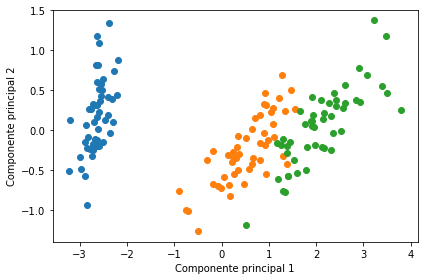

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for y_ in np.unique(y):
    mask = y == y_
    ax.scatter(X_reduced[mask, 0], X_reduced[mask, 1])
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2');

Estos nuevas características parecen suficiente para separar las tres clases

:::{warning}

PCA no utiliza la información de clases para hacer la proyección. No siempre maximizar varianza resultará en mayor separabilidad de clases

:::

:::{seealso}

PCA recibe su nombre debido a que las nuevas características y su varianza están relacionadas a los vectores y valores propios de la matriz de correlación de las características originales. Puedes profundizar sobre este tema leyendo [esta presentación](https://docs.google.com/presentation/d/1YqYy5RTB2PJ6C7syMTZCleZqyc2MJVA2APqdBAIhjBw/edit#slide=id.p)

:::

## Herramientas de MLOps

Un concepto que se utiliza bastante hoy en día es [Machine Learning Operations](https://docs.microsoft.com/es-es/azure/machine-learning/concept-model-management-and-deployment) (MLOPs). MLOps se refiere a la implementación de prácticas de Development Operations (DevOps) en problemas de Machine Learning, entre ellas

- Integración y Entrega continuas ([CI/CD](https://www.redhat.com/en/topics/devops/what-is-ci-cd))
- Flujos automáticos de trabajo (workflows)
- Control de versiones (códigos pero también datos y modelos)
- Empaquetado de soluciones
- Orquestación de carga de inferencia

:::{seealso}

Para hacer CI/CD con modelos de ML recomiendo [CML](https://cml.dev/)

:::

:::{seealso}

Para administrar experimentos de Machine Learning existen herramientas de linea de comando como [`dvc exp`](https://dvc.org/doc/command-reference/exp) o dashboards como [Neptune](https://neptune.ai/product), [MLFlow](https://mlflow.org/) o [Comet](https://www.comet.ml/site/)

:::

MLOps está relacionado a los últimos 4 pasos del esquema MLE, estos eran

**Entrega y servicio de modelos** 

Se refiere a cómo se entrega o sirve el modelo y/o sus predicciones al usuario, por ejemplo

- Estático: El modelo es parte de un ejecutable que está instalado en la máquina del usuario
- Dinámico (on-premise): El usuario tiene un cliente instalado en su máquina el cual solicita actualizaciones periódicas de los parámetros del modelo (cliente y modelo están separados)
- Dinámico (cloud): El usuario sube los datos a un servidor en la nube y recibe las predicciones

:::{note}

Los modelos de scikit-learn son amigables con [serialización](https://joblib.readthedocs.io/en/latest/generated/joblib.dump.html). El modelo serializado puede ser cargado por un servicio web basado en [Flask](https://flask.palletsprojects.com/en/2.1.x/) que luego el cliente accede a través de una API Rest

:::

:::{seealso}

La herramienta [MLEM](https://mlem.ai/) de Iterative.ai facilita considerablemente el flujo anterior

:::

**Monitoreo y mantenimiento de modelos**

Se refiere a la inspección continua del desempeño del modelo en producción. Sea $X$ los datos de entrada al modelo e $Y$ la etiqueta a predecir, se define:

Data drift
: Situación en que la distribución $p(X)$ empieza a alejarse de la distribución original que se utilizó para entrenar el modelo. Esto puede deberse a que el problema es no-estacionario o a que hubo sesgo de muestreo al crear el dataset de entrenamiento

Prior probability shift
: Situación en que la distribución $p(Y)$ se aleja de la distribución original. Por ejemplo una clase deja de aparecer con tanta frecuencia y otra más originalmente más rara ocurre con mayor frecuencia. En el caso extremo podría aparecer una clase que originalmente no estaba en el dataset de entrenamiento

Concept drift
: Situación en que la distribución condicional $p(Y|X)$ cambia con respecto a la original y por lo tanto nuestro mapeo $Y=f(X)$ pierde validez. Está relacionada a situaciones externas: cambio en la interpretación de la etiqueta, aparición de una clase que no estaba considerada originalmente, pérdida de poder predictivo

:::{important}

Los *drift* puede identificarse comparando la distribución de los nuevos datos y predicciones con las de entrenamiento en base test estadísticos (por ejemplo Chi cuadrado o Kolmogorov-Smirov). En caso de detectar *drift*, debemos analizar las predicciones, etiquetar y reentrenar el modelo

:::

Adicional al desempeño, también se debe monitorear

- La disponibilidad del modelo
- La estabilidad numérica del modelo
- El consumo de recursos de hardware del modelo
